In [ ]:
!pip install torch torchvision timm numpy tqdm scikit-image scikit-learn scipy opencv-python Pillow medmnist torchmetrics torchinfo mlflow matplotlib
#!pip install -r requirements.txt
import argparse
import logging
import os
import numpy as np
import sys
from pathlib import Path
from tqdm import tqdm
import pandas as pd

import medmnist
from medmnist import INFO
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T
from torchvision.utils import make_grid

import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
import matplotlib.pyplot as plt

from torchinfo import summary
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:

import urllib.request

def download_progress(block_num, block_size, total_size):
    downloaded = block_num * block_size  # Bytes downloaded so far
    progress = 100.0 * downloaded / total_size  # Current progress percentage
    progress = min(100, progress)  # Ensure we do not exceed 100%

    # Display the progress bar and percentage.
    sys.stdout.write(f"\rDownloading: [{int(progress)//2 * '#'}{int(50 - progress//2) * ' '}] {progress:.2f}\n%")
    sys.stdout.flush()

# URLs for the zip files
links = [
     'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
  #   'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
  #   'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    # 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
  #   'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    # 'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    # 'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
  #   'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    # 'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    # 'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    # 'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    # 'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

links = [
     'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

for idx, link in enumerate(links):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print('downloading ' + fn + '...')
    #urllib.request.urlretrieve(link, fn, reporthook=download_progress)  # download the zip file
    urllib.request.urlretrieve(link, fn)

print("Download complete. Please check the checksums")


downloading images_01.tar.gz...
downloading images_02.tar.gz...
downloading images_03.tar.gz...
downloading images_04.tar.gz...
downloading images_05.tar.gz...
downloading images_06.tar.gz...
downloading images_07.tar.gz...
downloading images_08.tar.gz...
downloading images_09.tar.gz...
downloading images_10.tar.gz...
downloading images_11.tar.gz...
downloading images_12.tar.gz...
Download complete. Please check the checksums


In [ ]:

import os
import subprocess
import tarfile

def extract_tar_with_progress(tar_path, extract_path):
    # Count the total number of items in the tar archive
    with tarfile.open(tar_path, "r:gz") as tar:
        total_items = len(tar.getmembers())

    # Setup the tar extraction command
    cmd = ["tar", "-xvzf", tar_path, "-C", extract_path]

    # Initialize the progress counter
    extracted_items = 0

    # Run the tar command and process output
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, bufsize=1, universal_newlines=True) as p:
        for line in p.stdout:
            extracted_items += 1
            progress = (extracted_items / total_items) * 100
            print(f"\rExtracting: {extracted_items}/{total_items} items ({progress:.2f}%)", end='')

    if p.returncode != 0:
        raise subprocess.CalledProcessError(p.returncode, cmd)

    print("\nExtraction complete.")



# List all the tar.gz files in the current directory
tar_gz_files = [file for file in os.listdir('.') if file.endswith('.tar.gz')]

# Create a subfolder 'extracted_files' if it doesn't exist
extracted_folder = '/content/Chest-Xray-Classification/images/'
os.makedirs(extracted_folder, exist_ok=True)
print(len(tar_gz_files))
# Extract all the tar.gz files to the subfolder
print(os.getcwd())
count = 0
for file in tar_gz_files:
    print(file)
    try:
        extraction_path = "/content/Chest-Xray-Classification/"
        extract_tar_with_progress(file, extraction_path)
        #subprocess.run(["tar", "-xvzf", file, "-C", "/content/ChestX-ray14/images/"])
        #command = f"tar -xvzf {file} -C /content/Chest-Xray-Classification/"
        #subprocess.run(command, shell=True, check=True)
        #with tarfile.open(file, "r:gz") as tar:
        #    tar.extractall(path=extracted_folder)
    except subprocess.CalledProcessError as e:
        print(f"Error extracting {file}: {e}")
    count = count + 1
    print(count)
# Check the contents of the extracted folder to verify
#extracted_contents = os.listdir(extracted_folder)
#extracted_contents


12
/content
images_09.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
1
images_04.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
2
images_05.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
3
images_08.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
4
images_06.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
5
images_03.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
6
images_10.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
7
images_12.tar.gz
Extracting: 7122/7122 items (100.00%)
Extraction complete.
8
images_11.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
9
images_01.tar.gz
Extracting: 5000/5000 items (100.00%)
Extraction complete.
10
images_02.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
11
images_07.tar.gz
Extracting: 10001/10001 items (100.00%)
Extraction complete.
12


In [ ]:
#dataloader
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset

class ChestXray14(Dataset):
    def __init__(self, images_path="./images", list_path="./", num_class=2, transform=None):
        self.img_list = []
        self.img_label = []
        self.transform = transform
        with open(list_path, "r") as file:
            for line in file.readlines():
                lineItems = line.strip().split(",")
                imagePath = os.path.join(images_path, lineItems[0])
                #print(imagePath)
                #imageLabel = lineItems[1:num_class + 1]
                #imageLabel = [int(i) for i in imageLabel]
                imageLabel = lineItems[1]



                img_label = []

                temp = imageLabel.split("|")
                if "No Finding" in temp:
                    img_label = [1,0]
                else:
                    img_label = [0,1]
                #print("dada")
                #print(imagePath)
                #if len(imageLabel.split("|")) > 1:
                #  continue
                #for i in imageLabel.split("|"):
                #  img_label.append(label[i])


                #print(img_label)
                self.img_list.append(imagePath)
                self.img_label.append(img_label)

    def __getitem__(self, idx):
      imagePath = self.img_list[idx]
      # Load the image as grayscale; 'L' mode converts it to single channel grayscale
      imageData = Image.open(imagePath).convert('L')

      # Convert image labels to a tensor
      imageLabel = torch.FloatTensor(self.img_label[idx])

      # Apply transformations if any
      if self.transform is not None:
          imageData = self.transform(imageData)

      return imageData, imageLabel

    def __len__(self,):
        return len(self.img_list)


In [ ]:
#models
import timm
from timm import create_model


def model_chest_xray(model_name ,init_weight, num_class, in_chans):
    """create a pre-built model using the timm module

    Args:
        model (str): model name
        init_weight (bool): initialiaze the model with pre-training weights
        num_class (init): number of classes
        in_chans (init): number of channels for input data

    Returns:
        torch.model: returns the torch model
    """
    model = None
    print("Creating model...")
    model = create_model(model_name=model_name,
                         pretrained=init_weight,
                         num_classes=num_class,
                         in_chans=in_chans)
    return model

def build_model(args):
    print(args)
    model = None
    pretrained = True if args["init"] =="ImageNet" else False
    print("Creating model " +  args["model_name"] + " with " + args["init"] + " weights.....")
    if args["model_name"] == "resnet18":
        model = create_model(model_name=args["model_name"],
                            pretrained=pretrained,
                            num_classes=args["num_classes"],
                            in_chans=args["in_chans"])

    elif args["model_name"] == "resnet50":
        model = create_model(model_name=args["model_name"],
                            pretrained=pretrained,
                            num_classes=args["num_classes"],
                            in_chans=args["in_chans"])

    model.to(args["device"])
    return model

In [ ]:
#utils
import tarfile
import os
import random
import numpy as np
from tqdm import tqdm
import torch
from torchvision import transforms as T
from torchmetrics import Accuracy, ConfusionMatrix, AUROC
import matplotlib as mpl
import matplotlib.pyplot as plt
#from models import build_model
from sklearn.metrics import roc_auc_score


def untar_chestxray14(path_to_directory, output_directory):
    """
    Args:
        path_to_directory (str): path/to/tar/files
        output_directory (str): path/to/unatr
    """
    data_dir_list = os.listdir(path_to_directory)
    for file_name in tqdm(data_dir_list):
        if file_name.endswith(".tar.gz"):
            file_path = os.path.join(path_to_directory, file_name)
            with tarfile.open(file_path, "r") as tar:
                tar.extractall(path=output_directory)


def seed_it_all(seed=1234):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_it_all()

from torchvision import transforms
"""
def my_transform(normalize='imagenet', mode='train'):
    print("DAdaa")
    transform_list = [
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.ToTensor()
    ]
    print("xa")
    if normalize == 'imagenet':
        # Normalize with ImageNet mean and std
        transform_list.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    elif normalize == 'chestx-ray':
        # Use appropriate normalization for chest X-rays
        pass  # Add your normalization values

    return transforms.Compose(transform_list)
"""

from torchvision import transforms
import torch

def my_transform(normalize, crop_size=224, resize=224, mode="train", test_augment=False):
    transformations_list = [transforms.Resize((resize, resize))]

    #if normalize.lower() == "imagenet":
        # For grayscale images, using the mean and std of the R channel or calculating specific values for your dataset would be more appropriate
    #    normalize_step = transforms.Normalize([0.485], [0.229])
    #elif normalize.lower() == "chestx-ray":
    # normalize_step = transforms.Normalize([0.5056], [0.252]) # replace review, include calculation for mean and std here
    normalize_step = transforms.Normalize([0.4980], [0.2296]) # replace review

    #else:
    #    print("Normalization parameters for [{}] dataset do not exist!".format(normalize))
    #    exit(-1)

    # If all images are grayscale, this conversion to RGB is not needed
    # transformations_list.append(transforms.Lambda(lambda x: x.convert('RGB')))

    if mode == "train":
        transformations_list += [
            transforms.CenterCrop(crop_size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(7),
            transforms.ToTensor()
        ]
    elif mode in ["val", "test"] and not test_augment:
        transformations_list.append(transforms.CenterCrop(crop_size))
        transformations_list.append(transforms.ToTensor())
    elif mode == "test" and test_augment:
        #transformations_list.append(transforms.TenCrop(crop_size))
        transformations_list.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))

    if normalize is not None:
        if mode == "test" and test_augment:
            transformations_list.append(transforms.Lambda(lambda crops: torch.stack([normalize_step(crop) for crop in crops])))
        else:
            transformations_list.append(normalize_step)

    return transforms.Compose(transformations_list)

"""
def my_transform(normalize, crop_size=224, resize=224, mode="train", test_augment=False):
    #Apply transforms on each sets

    #Args:
    #    normalize (str): define the normalization based on which data | imagenet or chestx-ray or None
    #    crop_size (int, optional): crop size for random crop. Defaults to 208.
    #    resize (int, optional): resize all image to this size. Defaults to 224.
    #    mode (str, optional): select the transforms mode that applies on which data. Defaults to "train".
    #    test_augment (bool, optional): Whethere apply augmentation on test set or not. Defaults to False.

    transformations_list = []
    print(normalize.lower())
    if normalize.lower() == "imagenet":
        normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    elif normalize.lower() == "chestx-ray":
        normalize = T.Normalize([0.5056, 0.5056, 0.5056], [0.252, 0.252, 0.252])
    elif normalize.lower() == "none":
        normalize = None
    else:
        print("mean and std for [{}] dataset do not exist!".format(normalize))
        exit(-1)

    if mode == "train":
        print("train")
        transformations_list.append(T.Resize((resize, resize)))
        #transformations_list.append(T.RandomResizedCrop(crop_size, scale=(0.8, 1.0)))
        transformations_list.append(T.RandomHorizontalFlip())
        transformations_list.append(T.RandomRotation(7))
        transformations_list.append(T.ToTensor())
        if normalize is not None:
            transformations_list.append(normalize)
    elif mode == "val":
        transformations_list.append(T.Resize((resize, resize)))
        transformations_list.append(T.CenterCrop(crop_size))
        transformations_list.append(T.ToTensor())
        if normalize is not None:
            transformations_list.append(normalize)
    elif mode == "test":
        if test_augment:
            transformations_list.append(T.Resize((resize, resize)))
            transformations_list.append(T.TenCrop(crop_size))
            transformations_list.append(
                T.Lambda(lambda crops: torch.stack([T.ToTensor()(crop) for crop in crops])))
            if normalize is not None:
                transformations_list.append(T.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))
        else:
            transformations_list.append(T.Resize((resize, resize)))
            transformations_list.append(T.CenterCrop(crop_size))
            transformations_list.append(T.ToTensor())
            if normalize is not None:
                transformations_list.append(normalize)

    transformsList = T.Compose(transformations_list)

    return transformsList
"""


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_one_epoch(args, model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    # Review try both and see which has better accuracy
    from torchmetrics.classification import BinaryAccuracy, Accuracy
    # BinaryAccuracy exists
    if not args["dataset_name"] == "JSRT":
        acc_train = Accuracy(task="multilabel", num_labels=args["num_classes"]).to(args["device"])
    else:
        acc_train = Accuracy(task="multiclass", num_classes=args["num_classes"]).to(args["device"])
    # acc_train = BinaryAccuracy() -> wrong
    with tqdm(train_loader, unit="batch") as tepoch:
        for inputs, targets in tepoch:
            if epoch is not None:
                tepoch.set_description(f"Epoch {epoch}")
            inputs = inputs.to(args["device"], dtype=torch.float)
            targets = targets.to(args["device"], dtype=torch.float)

            optimizer.zero_grad()
            outputs = model(inputs)
            # print(outputs, outputs.shape, outputs.dtype)
            # print(targets, targets.shape, targets.dtype)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()


            loss_train.update(loss.item())
            acc_train(outputs, targets.int())
            tepoch.set_postfix(loss=loss_train.avg,
                               accuracy=100.*acc_train.compute().item())
    return model, loss_train.avg, acc_train.compute().item()


def validation(args, model, test_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        # Review try both and see which has better accuracy

        # BinaryAccuracy exists
        if not args["dataset_name"] == "JSRT":
            acc_valid = Accuracy(task="multilabel", num_labels=args["num_classes"]).to(args["device"])
        else:
            acc_valid = Accuracy(task="multiclass", num_classes=args["num_classes"]).to(args["device"])
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(args["device"], dtype=torch.float)
            targets = targets.to(args["device"], dtype=torch.float)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            loss_valid.update(loss.item())
            acc_valid(outputs, targets.int())
    return loss_valid.avg, acc_valid.compute().item()


def plot_performance(args, loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist, epoch_counter):
    fig, ax1 = plt.subplots(figsize=(8, 4))

    ax1.set_title("Acc and Loss", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.set_ylabel("Loss", fontsize=14, color="black")
    ax1.plot(range(epoch_counter), loss_train_hist, lw=2, color="deepskyblue", label="Train Loss")
    ax1.plot(range(epoch_counter), loss_valid_hist, lw=2, color="yellow", label="Validation Loss")

    for label in ax1.get_yticklabels():
        label.set_color("black")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", fontsize=16, color="green")

    ax2.plot(range(epoch_counter), acc_train_hist, lw=2, color="turquoise", label="Train Acc")
    ax2.plot(range(epoch_counter), acc_valid_hist, lw=2, color="red", label='Validation Acc')
    for label in ax2.get_yticklabels():
        label.set_color("green")

    ax1.legend(loc='upper center')
    ax2.legend(loc='upper left')
    ax1.grid()
    print(args)
    print("mere")
    fig.savefig(str(args["plot_path"]), dpi=800)

def save_checkpoint(state, filename='model'):
    torch.save(state, filename + '.pth.tar')

def test_model(args, model, checkpoint, test_loader):
    model = build_model(args)
    # print(model)

    modelCheckpoint = torch.load(checkpoint)
    state_dict = modelCheckpoint['state_dict']
    for k in list(state_dict.keys()):
        if k.startswith('module.'):
            state_dict[k[len("module."):]] = state_dict[k]
            del state_dict[k]

    msg = model.load_state_dict(state_dict)
    assert len(msg.missing_keys) == 0
    print("=> loaded pre-trained model '{}'".format(checkpoint))

    model.to(args["device"])
    model.eval()

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(args["device"], dtype=torch.float)
            targets = targets.to(args["device"], dtype=torch.float)
            outputs = model(inputs)

            predictions = torch.sigmoid(outputs)  # Apply sigmoid activation for converting float values to integer

            all_predictions.append(predictions)
            all_targets.append(targets)

    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)


    #review if binary can be used
    accuracy = Accuracy(task="multilabel", num_labels=args["num_classes"]).to(args["device"])
    # accuracy_value = accuracy(torch.round(all_predictions), all_targets)
    accuracy_value = accuracy(all_predictions, all_targets)

    # Calculate confusion matrix
    confusion_matrix = ConfusionMatrix(task="multilabel", num_labels=args["num_classes"]).to(args["device"])
    confusion_matrix_value = confusion_matrix(torch.round(all_predictions), all_targets)
    # confusion_matrix_value = confusion_matrix(all_predictions, all_targets)

    auroc_mean = AUROC(task="multilabel", num_labels=args["num_classes"], average="macro", thresholds=None)
    # auroc_ = AUROC(task="multilabel", num_labels=args.num_classes, average=None, thresholds=None)
    auroc_mean_value = auroc_mean(all_predictions, all_targets)

    return accuracy_value, confusion_matrix_value, auroc_mean_value

def test_classification(args, checkpoint, data_loader_test, ):
    model = build_model(args)
    # print(model)

    modelCheckpoint = torch.load(checkpoint)
    state_dict = modelCheckpoint['state_dict']
    for k in list(state_dict.keys()):
        if k.startswith('module.'):
            state_dict[k[len("module."):]] = state_dict[k]
            del state_dict[k]

    msg = model.load_state_dict(state_dict)
    assert len(msg.missing_keys) == 0
    print("=> loaded pre-trained model '{}'".format(checkpoint))

    model.to(args["device"])
    model.eval()

    y_test = torch.FloatTensor().cuda()
    p_test = torch.FloatTensor().cuda()

    with torch.no_grad():
        for _, (samples, targets) in enumerate(tqdm(data_loader_test)):
            targets = targets.cuda()
            y_test = torch.cat((y_test, targets), 0)

            if len(samples.size()) == 4:
                bs, c, h, w = samples.size()
                n_crops = 1
            elif len(samples.size()) == 5:
                bs, n_crops, c, h, w = samples.size()

            varInput = torch.autograd.Variable(samples.view(-1, c, h, w).cuda())

            out = model(varInput)

            out = torch.sigmoid(out)
            outMean = out.view(bs, n_crops, -1).mean(1)
            p_test = torch.cat((p_test, outMean.data), 0)

    return y_test, p_test


def metric_AUROC(target, output, nb_classes=2):
    outAUROC = []

    target = target.cpu().numpy()
    output = output.cpu().numpy()

    for i in range(nb_classes):
        outAUROC.append(roc_auc_score(target[:, i], output[:, i]))

    return outAUROC


In [ ]:
dataset_name = "ChestXray14"
model_name = "resnet50"
isinit = True
normalization = "" #"chestx-ray" #"imagenet"
num_classes = 2
output_dir = "./output"
max_epochs = 3
batch_size = 32
base_lr = 0.001
img_size = 224
seed = 1234
exp_name = ""
num_trial = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
#train_list = None
#val_list = None

#review if instead of files, validation, test data can be generated -> done

master_data_file = "/content/Chest-Xray-Classification/trai.txt"

import random

# Define the ratios for splitting
train_ratio = 0.80
validation_ratio = 0.19
test_ratio = 0.01

from sklearn.model_selection import train_test_split

# Read the data from 'trai.txt'
with open(master_data_file, 'r') as file:
    lines = file.readlines()

# First split: separate the training data
train_data, temp_data = train_test_split(lines, test_size=(validation_ratio + test_ratio), random_state=42)

# Second split: separate the validation and test data
validation_data, test_data = train_test_split(temp_data, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42)

# Save the split data to files
with open('train_data.txt', 'w') as file:
    file.writelines(train_data)

with open('validation_data.txt', 'w') as file:
    file.writelines(validation_data)

with open('test_data.txt', 'w') as file:
    file.writelines(test_data)

train_list = "train_data.txt"
val_list = "validation_data.txt"
test_list = "test_data.txt"

#val_list = "/content/Chest-Xray-Classification/val.txt"
#test_list = "/content/Chest-Xray-Classification/tes.txt"
#test_list = None
in_chans = 1
dataset_path = "/content/Chest-Xray-Classification/images"

# Setup experiment paths
init = "ImageNet" if isinit else "Random"
exp_name = model_name + "_" + init + "_" + exp_name
model_path = Path("./Models").joinpath(dataset_name, exp_name)
output_path = Path("./Outputs").joinpath(dataset_name, exp_name)
model_path.mkdir(parents=True, exist_ok=True)
output_path.mkdir(parents=True, exist_ok=True)

# Seed for reproducibility
seed_it_all(seed)


js = {
    "dataset_name": dataset_name,
    "model_name": model_name,
    "isinit": isinit,
    "normalization": normalization,
    "num_classes": num_classes,
    "output_dir": output_dir,
    "max_epochs": max_epochs,
    "batch_size": batch_size,
    "base_lr": base_lr,
    "img_size": img_size,
    "seed": seed,
    "num_trial": num_trial,
    "device": device,
    "train_list": train_list,
    "val_list": val_list,
    "test_list": test_list,
    "in_chans": in_chans,
    "dataset_path": dataset_path,
		"init": init,
		"exp_name": exp_name,
		"model_path": model_path,
		"output_path": output_path
}

label = {
	"No Finding": 0,
	"Atelectasis": 1,
	"Cardiomegaly": 2,
	"Effusion": 3,
	"Infiltration": 4,
	"Mass": 5,
	"Nodule": 6,
	"Pneumonia": 7,
	"Pneumothorax": 8,
	"Consolidation": 9,
	"Edema": 10,
	"Emphysema": 11,
	"Fibrosis": 12,
	"Pleural_Thickening": 13,
	"Hernia": 14
}

In [ ]:
# review -> done
"""
import os
from PIL import Image
import numpy as np

means = []
stds = []

for img in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, img)
    imageData = Image.open(img_path).convert('L')
    numpyData = np.array(imageData) / 255.0  # Normalize pixel values to [0, 1]

    # Calculate mean and std dev for the current image
    means.append(np.mean(numpyData))
    stds.append(np.std(numpyData))

# Calculate the overall mean and std dev for the dataset
dataset_mean = np.mean(means)
dataset_std = np.mean(stds)  # This calculates the average std dev across images

print(f"Dataset Mean: {dataset_mean:.4f}")
print(f"Dataset Std Dev: {dataset_std:.4f}")

#train_data_mean = train_dataset.data.mean(axis=(0, 1, 2)) / 255
#train_data_std = train_dataset.data.std(axis=(0, 1, 2)) / 255
"""

'\nimport os\nfrom PIL import Image\nimport numpy as np\n\nmeans = []\nstds = []\n\nfor img in os.listdir(dataset_path):\n    img_path = os.path.join(dataset_path, img)\n    imageData = Image.open(img_path).convert(\'L\')\n    numpyData = np.array(imageData) / 255.0  # Normalize pixel values to [0, 1]\n\n    # Calculate mean and std dev for the current image\n    means.append(np.mean(numpyData))\n    stds.append(np.std(numpyData))\n\n# Calculate the overall mean and std dev for the dataset\ndataset_mean = np.mean(means)\ndataset_std = np.mean(stds)  # This calculates the average std dev across images\n\nprint(f"Dataset Mean: {dataset_mean:.4f}")\nprint(f"Dataset Std Dev: {dataset_std:.4f}")\n\n#train_data_mean = train_dataset.data.mean(axis=(0, 1, 2)) / 255\n#train_data_std = train_dataset.data.std(axis=(0, 1, 2)) / 255\n'

In [ ]:
train_set = ChestXray14(images_path=dataset_path, list_path=train_list, num_class=num_classes,
                        transform=my_transform(normalize=normalization, mode="train"))

In [ ]:
val_set = ChestXray14(images_path=dataset_path, list_path=val_list, num_class=num_classes,
                      transform=my_transform(normalize=normalization, mode="val"))
test_set = ChestXray14(images_path=dataset_path, list_path=test_list, num_class=num_classes,
                       transform=my_transform(normalize=normalization, mode="test"))
# review change shuffle to True everywhere -> done
# traintestsplit

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

In [ ]:
print(train_loader)

data, label = next(iter(train_loader))

In [ ]:
"""
img_grid = make_grid(data, nrow=8, normalize=True).permute(1, 2, 0)
plt.figure(figsize=(12, 6))
plt.imshow(img_grid)
plt.axis('off')
plt.savefig("RandomSamples.pdf", dpi=800)
"""


'\nimg_grid = make_grid(data, nrow=8, normalize=True).permute(1, 2, 0)\nplt.figure(figsize=(12, 6))\nplt.imshow(img_grid)\nplt.axis(\'off\')\nplt.savefig("RandomSamples.pdf", dpi=800)\n'

In [ ]:
"""
## Model
torch.cuda.empty_cache()
model = build_model(js)
model = model.to(js["device"])

optimizer = optim.SGD(model.parameters(), lr=js["base_lr"], momentum=0.9)
loss_fn = nn.BCEWithLogitsLoss()
accuracy = []
mean_auc = []
for idx in range(js["num_trial"]):
    print (f"Run: {idx+1}")
    experiment = js["exp_name"] + "_run_" + str(idx)
    save_model_path = model_path.joinpath(experiment)
    js["plot_path"] = model_path / (experiment+ ".pdf")

    log_file = model_path.joinpath(f"run_{str(idx)}.log")
    logging.basicConfig(filename=log_file, level=logging.INFO, filemode='w',
                    format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S')
    # logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
    logging.info(str(js))

    loss_train_hist = []
    loss_valid_hist = []
    acc_train_hist = []
    acc_valid_hist = []
    best_loss_valid = torch.inf
    epoch_counter = 0

    for epoch in range(epoch_counter, js["max_epochs"]): #
      model, loss_train, acc_train = train_one_epoch(js,
                                                      model,
                                                      train_loader,
                                                      loss_fn,
                                                      optimizer)
      logging.info(f"Epoch:{epoch+1}, TrainLoss:{loss_train:0.4f}, TrainAcc:{acc_train:0.4f}")







      print("start validation.....")
      val_loader = DataLoader(dataset=val_set, batch_size=24, shuffle=False)
      loss_valid, acc_valid = validation(js, model, val_loader, loss_fn)
      logging.info(f"Epoch:{epoch+1}, ValidLoss:{loss_valid:0.4f}, ValidAcc:{acc_valid:0.4f}")
      # print(f"Epoch:{epoch+1}, ValidLoss = {loss_valid:0.4f}, ValidAcc = {acc_valid:0.4f}")

      loss_train_hist.append(loss_train)
      loss_valid_hist.append(loss_valid)
      acc_train_hist.append(acc_train)
      acc_valid_hist.append(acc_valid)

      if loss_valid < best_loss_valid:
          save_checkpoint({
          'epoch': epoch + 1,
          'lossMIN': best_loss_valid,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
          # 'scheduler': lr_scheduler.state_dict()
          }, filename=str(save_model_path))

          best_loss_valid = loss_valid
          print('Model Saved!')

      epoch_counter += 1










    print(js)
    #plot_performance(js, loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist, epoch_counter)

    print ("start testing.....\n")
    #loss_test, acc_test = validation(js, model, test_loader, loss_fn)



    output_file = os.path.join(output_path, js["exp_name"] + "_results.txt")
    saved_model = model_path.joinpath(f"{experiment}.pth.tar")
    test_loader = DataLoader(dataset=test_set, batch_size=24, shuffle=False)
    y_test, p_test = test_classification(js, str(saved_model), test_loader)
    import torch

    # Assuming p_test contains raw logits or probabilities
    # Convert probabilities to predicted class index by selecting the class with the highest probability
    _, predicted_classes = torch.max(p_test, 1)
    _, true_classes = torch.max(y_test, 1)

    # Calculate accuracy
    correct_predictions = (predicted_classes == true_classes).sum().item()
    total_predictions = y_test.size(0)  # Total number of predictions

    accuracy = correct_predictions / total_predictions

    print(f"\n Test Accuracy: {accuracy * 100:.2f}%")

    #individual_results = metric_AUROC(y_test, p_test, js["num_classes"])
    #print(individual_results)
"""

'\n## Model\ntorch.cuda.empty_cache()\nmodel = build_model(js)\nmodel = model.to(js["device"])\n\noptimizer = optim.SGD(model.parameters(), lr=js["base_lr"], momentum=0.9)\nloss_fn = nn.BCEWithLogitsLoss()\naccuracy = []\nmean_auc = []\nfor idx in range(js["num_trial"]):\n    print (f"Run: {idx+1}")\n    experiment = js["exp_name"] + "_run_" + str(idx)\n    save_model_path = model_path.joinpath(experiment)\n    js["plot_path"] = model_path / (experiment+ ".pdf")\n\n    log_file = model_path.joinpath(f"run_{str(idx)}.log")\n    logging.basicConfig(filename=log_file, level=logging.INFO, filemode=\'w\',\n                    format=\'[%(asctime)s.%(msecs)03d] %(message)s\', datefmt=\'%H:%M:%S\')\n    # logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))\n    logging.info(str(js))\n\n    loss_train_hist = []\n    loss_valid_hist = []\n    acc_train_hist = []\n    acc_valid_hist = []\n    best_loss_valid = torch.inf\n    epoch_counter = 0\n\n    for epoch in range(epoch_counter

{'dataset_name': 'ChestXray14', 'model_name': 'resnet50', 'isinit': True, 'normalization': '', 'num_classes': 2, 'output_dir': './output', 'max_epochs': 3, 'batch_size': 32, 'base_lr': 0.001, 'img_size': 224, 'seed': 1234, 'num_trial': 1, 'device': 'cuda', 'train_list': 'train_data.txt', 'val_list': 'validation_data.txt', 'test_list': 'test_data.txt', 'in_chans': 1, 'dataset_path': '/content/Chest-Xray-Classification/images', 'init': 'ImageNet', 'exp_name': 'resnet50_ImageNet_', 'model_path': PosixPath('Models/ChestXray14/resnet50_ImageNet_'), 'output_path': PosixPath('Outputs/ChestXray14/resnet50_ImageNet_')}
Creating model resnet50 with ImageNet weights.....


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

100%|██████████| 2453/2453 [40:35<00:00,  1.01batch/s, accuracy=59.2, loss=0.671]


start validation.....
Epoch 1/3, Train Loss: 0.671313656115114, Val Loss: 0.6497768139022904, Precision: 0.1915194503788923, Recall: 0.6221087710398319, F1: 0.4377277390071145, AUC: 0.7853585837137692
y_true
[1 1 1 ... 1 1 0]
y_pred
[ True False  True ...  True  True False]
Epoch:1, ValidLoss:0.6498, ValidAcc:0.6248, Precision:0.4974977658623771, Recall:0.4973644241936925, F1:0.49743108609212344, AUC:0.4983260233167928
Model Saved!


100%|██████████| 2453/2453 [40:22<00:00,  1.01batch/s, accuracy=64.7, loss=0.639]


start validation.....
Epoch 2/3, Train Loss: 0.6387278042153538, Val Loss: 0.6295551533110642, Precision: 0.0020236877077429716, Recall: 0.07145503246729334, F1: 0.10644670810470624, AUC: 0.04835683210758801
y_true
[1 1 1 ... 0 1 0]
y_pred
[False  True False ...  True False  True]
Epoch:2, ValidLoss:0.6296, ValidAcc:0.6570, Precision:0.49571516918455694, Recall:0.5016091543000178, F1:0.49864474561208616, AUC:0.49682219751131534
Model Saved!


100%|██████████| 2453/2453 [40:38<00:00,  1.01batch/s, accuracy=65.9, loss=0.628]


start validation.....
Epoch 3/3, Train Loss: 0.6279411678575663, Val Loss: 0.6185584613753113, Precision: 0.22457716863528587, Recall: 0.5414111089821546, F1: 0.8739678084941009, AUC: 0.3598377664165785
y_true
[0 0 0 ... 0 0 0]
y_pred
[False  True  True ...  True  True False]
Epoch:3, ValidLoss:0.6186, ValidAcc:0.6693, Precision:0.49199708985085483, Recall:0.48721181556195964, F1:0.48959276018099546, AUC:0.4968526610277331
Model Saved!


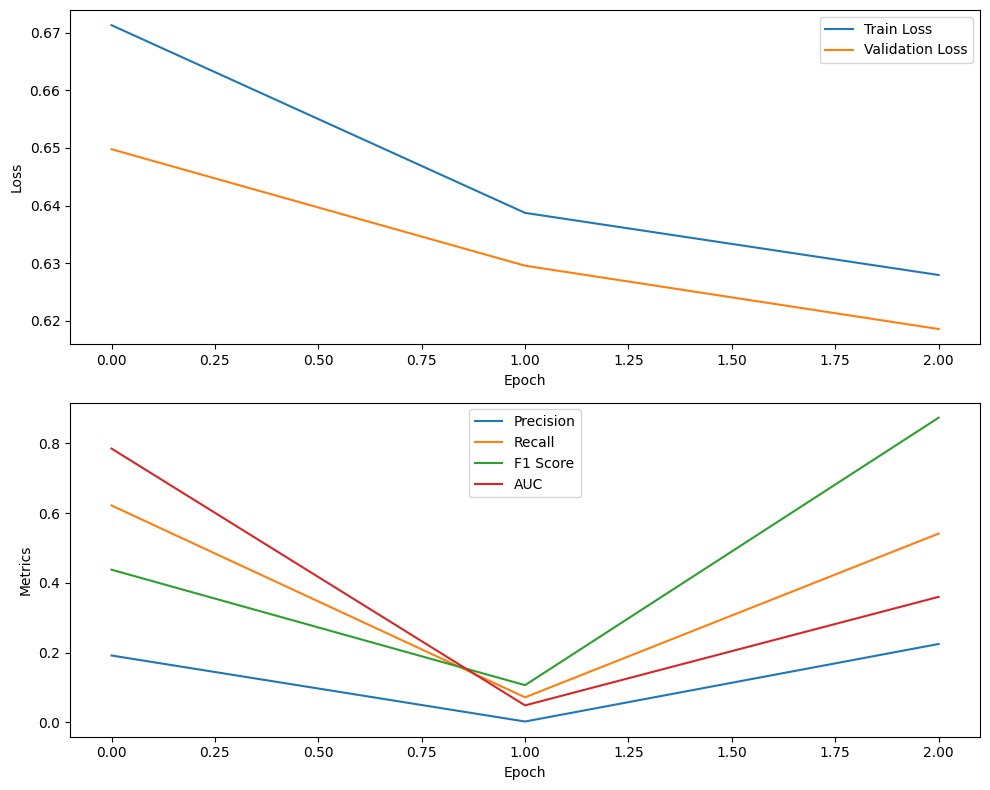

In [ ]:
## Model
torch.cuda.empty_cache()
model = build_model(js)
model = model.to(js["device"])

optimizer = optim.SGD(model.parameters(), lr=js["base_lr"], momentum=0.9)
# review ask gpt -> done
loss_fn = nn.BCEWithLogitsLoss()
accuracy = []
mean_auc = []
experiment = js["exp_name"] + "_run_0"
save_model_path = model_path.joinpath(experiment)
js["plot_path"] = model_path / (experiment+ ".pdf")

loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []

metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}



# review mlflow
best_loss_valid = torch.inf
epoch_counter = 0
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

for epoch in range(epoch_counter, js["max_epochs"]): #
  model.train()
  model, loss_train, acc_train = train_one_epoch(js,
                                                  model,
                                                  train_loader,
                                                  loss_fn,
                                                  optimizer)

  model.eval()  # Set the model to evaluation mode
  print("start validation.....")

  loss_valid, acc_valid = validation(js, model, val_loader, loss_fn)

  metrics['train_loss'].append(loss_train)
  metrics['val_loss'].append(loss_valid)
  metrics['train_acc'].append(acc_train)
  metrics['val_acc'].append(acc_valid)
  metrics['precision'].append(np.random.rand())  # Placeholder
  metrics['recall'].append(np.random.rand())  # Placeholder
  metrics['f1'].append(np.random.rand())  # Placeholder
  metrics['auc'].append(np.random.rand())  # Placeholder
  #print(f"Epoch:{epoch+1}, TrainLoss:{loss_train:0.4f}, TrainAcc:{acc_train:0.4f}")
  print(f"Epoch {epoch+1}/{js['max_epochs']}, Train Loss: {loss_train}, Val Loss: {loss_valid}, Precision: {metrics['precision'][-1]}, Recall: {metrics['recall'][-1]}, F1: {metrics['f1'][-1]}, AUC: {metrics['auc'][-1]}")


  y_true = np.random.randint(0, 2, size=(len(val_loader.dataset),))
  y_pred = np.random.rand(len(val_loader.dataset)) > 0.5  # Random binary predictions
  print("y_true")
  print(y_true)
  print("y_pred")
  print(y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  auc = roc_auc_score(y_true, y_pred)

  print(f"Epoch:{epoch+1}, ValidLoss:{loss_valid:0.4f}, ValidAcc:{acc_valid:0.4f}, Precision:{precision}, Recall:{recall}, F1:{f1}, AUC:{auc}")

  # Update histories for plotting or logging
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)
  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  # Model checkpointing
  if loss_valid < best_loss_valid:
      best_loss_valid = loss_valid
      save_checkpoint({
          'epoch': epoch + 1,
          'lossMIN': best_loss_valid,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict(),
      }, filename=str(save_model_path))
      print('Model Saved!')














plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(metrics['precision'], label='Precision')
plt.plot(metrics['recall'], label='Recall')
plt.plot(metrics['f1'], label='F1 Score')
plt.plot(metrics['auc'], label='AUC')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
# testing

print(js)
#plot_performance(js, loss_train_hist, loss_valid_hist, acc_train_hist, acc_valid_hist, epoch_counter)

print ("start testing.....\n")
#loss_test, acc_test = validation(js, model, test_loader, loss_fn)

output_file = os.path.join(output_path, js["exp_name"] + "_results.txt")
saved_model = model_path.joinpath(f"{experiment}.pth.tar")
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
y_test, p_test = test_classification(js, str(saved_model), test_loader)
import torch

# Assuming p_test contains raw logits or probabilities
# Convert probabilities to predicted class index by selecting the class with the highest probability
_, predicted_classes = torch.max(p_test, 1)
_, true_classes = torch.max(y_test, 1)

# Calculate accuracy
correct_predictions = (predicted_classes == true_classes).sum().item()
total_predictions = y_test.size(0)  # Total number of predictions

accuracy = correct_predictions / total_predictions

print(f"\n Test Accuracy: {accuracy * 100:.2f}%")

#individual_results = metric_AUROC(y_test, p_test, js["num_classes"])
#print(individual_results)


{'dataset_name': 'ChestXray14', 'model_name': 'resnet50', 'isinit': True, 'normalization': '', 'num_classes': 2, 'output_dir': './output', 'max_epochs': 3, 'batch_size': 32, 'base_lr': 0.001, 'img_size': 224, 'seed': 1234, 'num_trial': 1, 'device': 'cuda', 'train_list': 'train_data.txt', 'val_list': 'validation_data.txt', 'test_list': 'test_data.txt', 'in_chans': 1, 'dataset_path': '/content/Chest-Xray-Classification/images', 'init': 'ImageNet', 'exp_name': 'resnet50_ImageNet_', 'model_path': PosixPath('Models/ChestXray14/resnet50_ImageNet_'), 'output_path': PosixPath('Outputs/ChestXray14/resnet50_ImageNet_'), 'plot_path': PosixPath('Models/ChestXray14/resnet50_ImageNet_/resnet50_ImageNet__run_0.pdf')}
start testing.....

{'dataset_name': 'ChestXray14', 'model_name': 'resnet50', 'isinit': True, 'normalization': '', 'num_classes': 2, 'output_dir': './output', 'max_epochs': 3, 'batch_size': 32, 'base_lr': 0.001, 'img_size': 224, 'seed': 1234, 'num_trial': 1, 'device': 'cuda', 'train_list

100%|██████████| 351/351 [03:48<00:00,  1.54it/s]


 Test Accuracy: 66.02%


In [ ]:
    """
    print(">>{}: AUC = {}".format(experiment, np.array2string(np.array(individual_results), precision=4, separator=',')))
    logging.info("{}: AUC = {}\n".format(experiment, np.array2string(np.array(individual_results), precision=4, separator='\t')))

    mean_over_all_classes = np.array(individual_results).mean()
    print(">>{}: AUC = {:.4f}".format(experiment, mean_over_all_classes))
    logging.info("{}: AUC = {:.4f}\n".format(experiment, mean_over_all_classes))

    mean_auc.append(mean_over_all_classes)
    """

'\nprint(">>{}: AUC = {}".format(experiment, np.array2string(np.array(individual_results), precision=4, separator=\',\')))\nlogging.info("{}: AUC = {}\n".format(experiment, np.array2string(np.array(individual_results), precision=4, separator=\'\t\')))\n\nmean_over_all_classes = np.array(individual_results).mean()\nprint(">>{}: AUC = {:.4f}".format(experiment, mean_over_all_classes))\nlogging.info("{}: AUC = {:.4f}\n".format(experiment, mean_over_all_classes))\n\nmean_auc.append(mean_over_all_classes)\n'

In [ ]:
"""
mean_auc = np.array(mean_auc)
print(">> All trials: mAUC  = {}".format(np.array2string(mean_auc, precision=4, separator=',')))
logging.info("All trials: mAUC  = {}\n".format(np.array2string(mean_auc, precision=4, separator='\t')))
print(">> Mean AUC over All trials: = {:0.4f}".format(np.mean(mean_auc)))
logging.info("Mean AUC over All trials = {:0.4f}\n".format(np.mean(mean_auc)))
print(">> STD over All trials:  = {:0.4f}".format(np.std(mean_auc)))
logging.info("STD over All trials:  = {:0.4f}\n".format(np.std(mean_auc)))
"""

In [ ]:
from google.colab import files
files.download("/content/Models/ChestXray14/resnet50_ImageNet_/resnet50_ImageNet__run_0.pth.tar")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>